In [1]:
import setGPU
import os
import numpy as np
from collections import namedtuple
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../sarewt_orig/')))
sys.path.append(os.path.abspath(os.path.join('../../')))

import vae.vae_particle as vap
import vae.losses as losses
import pofah.util.experiment as expe
import pofah.util.sample_factory as safa
import util.data_generator as dage
import sarewt.data_reader as dare
import pofah.phase_space.cut_constants as cuts
import training as tra
import tensorflow.keras.layers as klayers
from importlib import reload
import tensorflow.keras.layers as klayers


setGPU: Setting GPU to: 7
tensorflow version:  2.3.0


In [2]:
import numba
print(numba.__version__)

0.51.2


In [3]:
# ********************************************************
#       runtime params
# ********************************************************

RunParameters = namedtuple('Parameters', 'run_n  \
 epochs train_total_n gen_part_n valid_total_n batch_n learning_rate max_lr_decay lambda_reg')
params = RunParameters(run_n=113, 
                    epochs=2, 
                    train_total_n=int(1e4), 
                    valid_total_n=int(1e4), 
                    gen_part_n=int(5e3), 
                    batch_n=50, 
                    learning_rate=0.001,
                    max_lr_decay=8, 
                    lambda_reg=0.0) # 'L1L2'

Parameters = namedtuple('Setting', 'name  input_shape  beta activation initializer conv_params conv_params_encoder conv_params_decoder with_bn conv_pooling \
                     conv_linking latent_dim ae_type kl_warmup_time kernel_ini_n')
setting = Parameters(
    name = 'PN',
input_shape=[(100,2),(100,3)],
beta=0.1, 
activation=klayers.LeakyReLU(alpha=0.1),
initializer='he_uniform',
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
conv_params = [(15, ([20,20,20])),(15, ([20,20,20]))],
conv_params_encoder = [],
conv_params_decoder = [10],  #[32,16,8]
with_bn = True,
conv_pooling = 'average',
conv_linking = 'sum' ,#concat or sum
latent_dim = 3,
ae_type = 'vae',  #ae or vae 
kl_warmup_time = 10,
kernel_ini_n = 0)



In [6]:
#Parameters = namedtuple("Parameters", Parameters._fields + Settings._fields)
#new_params = Parameters(*(params + setting))

In [8]:
#import json
#j = json.dumps((new_params._replace(activation='activation'))._asdict())

In [4]:
import vae.vae_base as vae_base
reload(vae_base)
import vae.vae_particlenet as vae_pn
reload(vae_pn)

vae = vae_pn.VAE_ParticleNet(name=setting.name,conv_params=setting.conv_params, conv_params_encoder=setting.conv_params_encoder,
                                            conv_params_decoder=setting.conv_params_decoder, with_bn=setting.conv_params_decoder, 
                                            conv_pooling=setting.conv_pooling,conv_linking=setting.conv_linking,
                                            input_shape=setting.input_shape,latent_dim=setting.latent_dim,ae_type=setting.ae_type,
                                            kl_warmup_time=setting.kl_warmup_time,activation=setting.activation )
vae.build()
#


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 2, 100)       0           points[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 100, 2)       0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf.linalg.matmul (TFOpLambda)   (None, 100, 100)     0           points[0][0]               

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input_0 (InputLayer)      [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
model_input_1 (InputLayer)      [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 3), (None, 3 2666        model_input_0[0][0]              
                                                                 model_input_1[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 100, 3)       8033        encoder[0][0]                  

In [5]:
# *******************************************************
#                       training options
# *******************************************************

optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)
loss_fn = losses.threeD_loss

In [6]:
import h5py

import ADgvae.utils.preprocessing as prepr
reload(prepr)

DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
filename_bg = DATA_PATH + 'QCD_training_data_100const_03_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [132]:
train_ds = tf.data.Dataset.from_tensor_slices((particles_bg[:10000,:,0:2],particles_bg[:10000,:,:]))

batched_dataset = train_ds.batch(256)
#for step, x_batch_train in enumerate(batched_dataset):
#    print(x_batch_train)
#    break

In [5]:
import pofah.path_constants.sample_dict_file_parts_input_vae as sdi
reload(sdi)

reload(expe)
experiment = expe.Experiment(params.run_n).setup(model_dir=True, fig_dir=True)
paths = safa.SamplePathDirFactory(sdi.path_dict)

# train (generator)
print('>>> Preparing training dataset generator')

reload(expe)
reload(safa)

import util.data_generator_particlenet as dage_pn
reload(dage_pn)



>>> Preparing training dataset generator


<module 'util.data_generator_particlenet' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py'>

In [8]:

#path = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/test_0.h5'
#data_train_generator_new = dage_pn.DataGeneratorDirectPrepr(path=path,sample_max_n=params.train_total_n, 
 #                                         batch_size = 256)



data_train_generator_new = dage_pn.DataGeneratorDirect(path=paths.sample_dir_path('qcdSide'), 
                                          sample_part_n=params.gen_part_n, 
                                          sample_max_n=params.train_total_n, 
                                          batch_size = 256,
                                          **cuts.global_cuts) # generate 10 M jet samples

ds = tf.data.Dataset.from_generator(
        data_train_generator_new, 
        (tf.float32,tf.float32), 
        (tf.TensorShape([None,100,2]), tf.TensorShape([None,100,3])))
        #([None,100,2],[None,100,3]))


ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
import time
# starting time
start = time.time()
i=0
for sample in ds:
    print(sample[0].shape,sample[1].shape)
    i+=1
    #print(sample[0],sample[1])
    if (i==100) : break
# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")


path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts
Samples read
(256, 100, 2) (256, 100, 3)
(256, 100, 2) (256, 100, 3)
(256, 100, 2) (256, 100, 3)
[DataGenerator]: __call__() yielded 1280 samples
(256, 100, 2) (256, 100, 3)
Runtime of the program is 31.55609440803528


In [1]:
import time


In [26]:

data_train_generator_new = dage_pn.DataGeneratorPerFile(path=paths.sample_dir_path('qcdSide'), 
                                          sample_max_n=params.train_total_n, 
                                          batch_size = 256,
                                          **cuts.global_cuts) # generate 10 M jet samples

ds = tf.data.Dataset.from_generator(
        data_train_generator_new, 
        (tf.float32,tf.float32), 
        (tf.TensorShape([None,100,2]), tf.TensorShape([None,100,3])))


ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [91]:
import h5py
import tensorflow as tf

class generator:
    def __init__(self):
        self.samples_read_n = 0
        
    def __call__(self, file,sample_max_n):
       # samples_read_n = 0
        with h5py.File(file, 'r')as inFile:
            samples = inFile['particle_bg']

            batch_size = 5000
            nb = samples.shape[0] // batch_size
            last_batch = samples.shape[0] % batch_size

            for ib in range(nb):
                print(ib)
                if sample_max_n is not None and (self.samples_read_n >= sample_max_n):
                    print(file,ib,self.samples_read_n)
                    self.samples_read_n = 0
                    break
                else :
                    yield samples[ib*batch_size:(ib+1)*batch_size,:,0:2], samples[ib*batch_size:(ib+1)*batch_size,:,:]
                self.samples_read_n += batch_size

           # if last_batch > 0:
           #     yield samples[-last_batch:,:,0:2], samples[-last_batch:,:,:]
                
                
                
path = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/'
filenames = [path+'test_0.h5',path+'test_1.h5'] #multiple files working, but in this case function 
#is called a new on each file, meaning that params.train_total_n is not global but applied to each file
#filenames = [path+'test_0.h5'] #multiple files working, but in this case function 
ds = tf.data.Dataset.from_tensor_slices(filenames) 
ds = ds.interleave(lambda filename: tf.data.Dataset.from_generator(
        generator(), 
        (tf.float32,tf.float32), 
        (tf.TensorShape([None,100,2]), tf.TensorShape([None,100,3])),
        args=(filename,params.train_total_n,)))
batched_dataset = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


valid_ds = tf.data.Dataset.from_tensor_slices(filenames) 
valid_ds = valid_ds.interleave(lambda filename: tf.data.Dataset.from_generator(
        generator(), 
        (tf.float32,tf.float32), 
        (tf.TensorShape([None,100,2]), tf.TensorShape([None,100,3])),
        args=(filename,params.train_total_n,)))
batched_dataset_valid = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [139]:
len(([1,2,3]))

3

In [15]:
import time

# starting time
start = time.time()

reload(tra)
import setGPU
trainer = tra.TrainerParticleNet(optimizer=optimizer, beta=setting.beta, patience=3, min_delta=0.03, max_lr_decay=params.max_lr_decay, lambda_reg=params.lambda_reg)

losses_reco, losses_valid = trainer.train(vae=vae, loss_fn=loss_fn,
                                         # train_ds=batched_dataset, valid_ds=batched_dataset_valid,
                                         # train_ds  = data_train_generator_new(),valid_ds=data_train_generator_new(),
                                                                           # train_ds=batched_dataset, valid_ds=batched_dataset,
                                          train_ds  = ds,valid_ds=ds,
                                          epochs=params.epochs, model_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")



### [11.8 13:19:5] Start of epoch 0
path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts
Samples read


UnknownError: TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function vstack at 0x7f9144120ca0>) found for signature:
 
 >>> vstack(list(array(float32, 3d, C))<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'vstack': File: numba/core/typing/npydecl.py: Line 833.
    With argument(s): '(list(array(float32, 3d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypeError: np.vstack(): expecting a non-empty tuple of arrays, got list(array(float32, 3d, C))<iv=None>
  raised from /cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numba/core/typing/npydecl.py:765

During: resolving callee type: Function(<function vstack at 0x7f9144120ca0>)
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (51)


File "util/data_generator_particlenet.py", line 51:
def constituents_to_input_samples(constituents, mask_j1, mask_j2): # -> np.ndarray
    <source elided>
        const_j2 = constituents[:,1,:,:][mask_j2]
        samples = np.vstack([const_j1, const_j2])
        ^

During: resolving callee type: type(CPUDispatcher(<function constituents_to_input_samples at 0x7f8fc4500940>))
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (59)

During: resolving callee type: type(CPUDispatcher(<function constituents_to_input_samples at 0x7f8fc4500940>))
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (59)


File "util/data_generator_particlenet.py", line 59:
def events_to_input_samples(constituents, features):
    <source elided>
    mask_j1, mask_j2 = mask_training_cuts(constituents, features)
    return constituents_to_input_samples(constituents, mask_j1, mask_j2)
    ^

Traceback (most recent call last):

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 961, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py", line 144, in __call__
    samples = events_to_input_samples(constituents, features)

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numba/core/dispatcher.py", line 415, in _compile_for_args
    error_rewrite(e, 'typing')

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numba/core/dispatcher.py", line 358, in error_rewrite
    reraise(type(e), e, None)

  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numba/core/utils.py", line 80, in reraise
    raise value.with_traceback(tb)

numba.core.errors.TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function vstack at 0x7f9144120ca0>) found for signature:
 
 >>> vstack(list(array(float32, 3d, C))<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'vstack': File: numba/core/typing/npydecl.py: Line 833.
    With argument(s): '(list(array(float32, 3d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypeError: np.vstack(): expecting a non-empty tuple of arrays, got list(array(float32, 3d, C))<iv=None>
  raised from /cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numba/core/typing/npydecl.py:765

During: resolving callee type: Function(<function vstack at 0x7f9144120ca0>)
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (51)


File "util/data_generator_particlenet.py", line 51:
def constituents_to_input_samples(constituents, mask_j1, mask_j2): # -> np.ndarray
    <source elided>
        const_j2 = constituents[:,1,:,:][mask_j2]
        samples = np.vstack([const_j1, const_j2])
        ^

During: resolving callee type: type(CPUDispatcher(<function constituents_to_input_samples at 0x7f8fc4500940>))
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (59)

During: resolving callee type: type(CPUDispatcher(<function constituents_to_input_samples at 0x7f8fc4500940>))
During: typing of call at /eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py (59)


File "util/data_generator_particlenet.py", line 59:
def events_to_input_samples(constituents, features):
    <source elided>
    mask_j1, mask_j2 = mask_training_cuts(constituents, features)
    return constituents_to_input_samples(constituents, mask_j1, mask_j2)
    ^



	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [6]:
import glob
import h5py
data_train = dage_pn.get_data_from_file(path=paths.sample_dir_path('qcdSideExt'),file_num=1,end=params.valid_total_n)
train_ds = tf.data.Dataset.from_tensor_slices((data_train[:,:,0:2],data_train[:,:,:])).batch(params.batch_n, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Opening file : /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_parts/qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_001.h5
>>> Normalizing features
Training data size 19688


In [7]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

sig_types = 'GtoWW35na,GtoWW15na,GtoWW35br,GtoWW15br'.split(',')
particles_sig_dict = {}
particles_sig_dict['ds'] = {}

for sig in sig_types:
    data_train = dage_pn.get_data_from_file(path=paths.sample_dir_path(sig),file_num=0,end=params.valid_total_n)
    sig_ds = tf.data.Dataset.from_tensor_slices((data_train[:,:,0:2],data_train[:,:,:])).batch(params.batch_n, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    particles_sig_dict['ds'][sig]= sig_ds

#signal_types = list(particles_sig_dict.keys()) 

Opening file : /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_NEW_parts/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_NEW_concat_000.h5
>>> Normalizing features
Training data size 19934
Opening file : /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_NEW_parts/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_NEW_concat_000.h5
>>> Normalizing features
Training data size 19747
Opening file : /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV_NEW_parts/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV_NEW_concat_000.h5
>>> Normalizing features
Training data size 19920
Opening file : /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_BROAD_13TeV_PU40_1.5TeV_NEW_parts/RSGraviton_WW_BROAD_13TeV_PU40_1.5TeV_NEW_concat_000.h5
>>> Normalizing features
Training data size 19743


{'GtoWW35na': <PrefetchDataset shapes: ((None, 100, 2), (None, 100, 3)), types: (tf.float32, tf.float32)>}

In [8]:
reload(tra)
import vae.layers as layers
loss_fn = losses.threeD_loss
import vae.vae_particlenet as vae_pn
reload(vae_pn)
from vae.vae_particlenet import VAE_ParticleNet
from tensorflow.keras.layers import LeakyReLU


#reco_bg, loss_bg_reco, loss_bg_kl = tra.predict_particle_net(vae.model, loss_fn, batched_dataset)
saved_path = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/VAE_models/run_13/'
#path=os.path.join(saved_path, 'best_so_far')
path=saved_path
vae = VAE_ParticleNet.from_saved_model(path=path)
beta= vae.beta

In [111]:
intermediate_layer_model = tf.keras.Model(inputs=vae.encoder.input,
                                          outputs=vae.encoder.get_layer('PN_1_act2').output)

In [112]:
intermediate_layer_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose (TensorFl (None, 2, 100)       0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa (None, 100, 2)       0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_BatchMatMulV2 (Tens (None, 100, 100)     0           points[0][0]         

In [113]:
def predict_func(model,test_ds):    
    predictions = []

    for step, x_batch_test in enumerate(test_ds):
        (coord_in, feats_in)  = x_batch_test
        # print('predicting batch {}'.format(step))
        predictions_batch = model(x_batch_test, training=False)
        predictions.append(predictions_batch.numpy())
    return np.concatenate(predictions, axis=0)

In [114]:
intermediate_output = predict_func(intermediate_layer_model,train_ds)

In [115]:
intermediate_output.shape

(19650, 100, 7, 64)

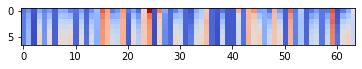

In [132]:
import matplotlib.pyplot as plt
import numpy as np ## to reshape
%matplotlib inline
#mean_out = np.mean(np.mean(intermediate_output,axis=1),axis=0)
fr
mean_out = np.mean(intermediate_output[:,50,:,:],axis=0)
plt.imshow(mean_out,cmap='coolwarm') 
# note that output should be reshape in 3 dimension

In [67]:
for i in range(len(vae.encoder.layers)):
    print(vae.encoder.layers[i].name)

points
tf_op_layer_Transpose
tf_op_layer_Mul
tf_op_layer_BatchMatMulV2
tf_op_layer_Mul_1
tf_op_layer_Sum
tf_op_layer_Mul_2
tf_op_layer_Sum_1
features
tf_op_layer_Sub
tf_op_layer_Transpose_1
tf_op_layer_Shape
tf_op_layer_AddV2
tf_op_layer_strided_slice_1
tf_op_layer_Neg
tf_op_layer_Range
tf_op_layer_TopKV2
tf_op_layer_Reshape
tf_op_layer_strided_slice
tf_op_layer_Tile
tf_op_layer_ExpandDims_1
tf_op_layer_concat
tf_op_layer_ExpandDims_2
tf_op_layer_GatherNd
tf_op_layer_Tile_1
tf_op_layer_Sub_1
PN_0_conv0
PN_0_bn0
PN_0_act0
PN_0_conv1
PN_0_bn1
PN_0_act1
PN_0_conv2
tf_op_layer_Transpose_2
PN_0_bn2
tf_op_layer_Mul_3
tf_op_layer_BatchMatMulV2_1
tf_op_layer_Mul_4
PN_0_act2
tf_op_layer_Sum_2
tf_op_layer_Mul_5
tf_op_layer_Sum_3
tf_op_layer_Mean
tf_op_layer_Sub_2
tf_op_layer_Transpose_3
tf_op_layer_Shape_1
tf_op_layer_AddV2_1
tf_op_layer_strided_slice_3
tf_op_layer_Neg_1
tf_op_layer_Range_1
tf_op_layer_TopKV2_1
tf_op_layer_Reshape_1
tf_op_layer_strided_slice_2
tf_op_layer_Tile_2
tf_op_layer_Expa

In [68]:
vae.encoder.input

[<tf.Tensor 'points:0' shape=(None, 100, 2) dtype=float32>,
 <tf.Tensor 'features:0' shape=(None, 100, 3) dtype=float32>]

In [62]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([vae.encoder.layers[0].input],
                                  [vae.encoder.layers[2].output])
layer_output = get_3rd_layer_output([train_ds])[0] ## pass as input image

Using TensorFlow backend.


AttributeError: module 'tensorflow' has no attribute 'get_default_session'

In [11]:


#_,_,vae = VAE_ParticleNet.load(path=os.path.join(saved_path, 'best_so_far'))


reco_bg, loss_bg_reco, loss_bg_kl = tra.predict_particle_net(vae.model, loss_fn, train_ds)
#reco_bg, loss_bg_reco, loss_bg_kl = tra.predict_particle_net(vae, loss_fn, batched_dataset)

particles_sig_dict['reco'] = {}
particles_sig_dict['loss'] = {}
particles_sig_dict['loss_kl'] = {}
for sig in sig_types:
    reco_sig, loss_sig_reco, loss_sig_kl = tra.predict_particle_net(vae.model, loss_fn, particles_sig_dict['ds'][sig])
    #reco_sig, loss_sig_reco, loss_sig_kl = tra.predict_particle_net(vae, loss_fn, particles_sig_dict['ds'][sig])
    particles_sig_dict['reco'][sig] = reco_sig
    particles_sig_dict['loss'][sig] = loss_sig_reco
    particles_sig_dict['loss_kl'][sig] = loss_sig_kl

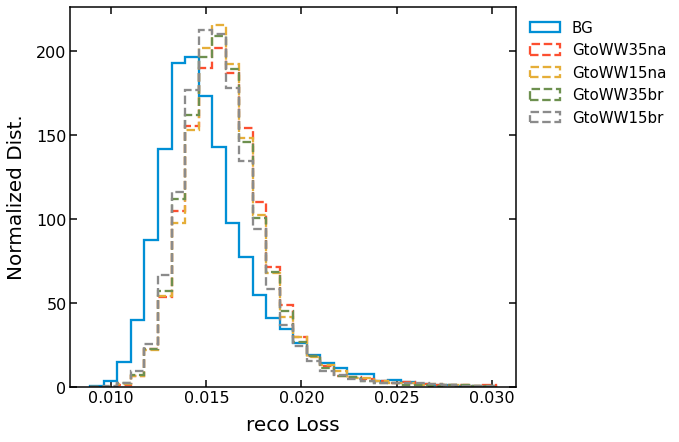

In [12]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for loss in [loss_bg_reco ]:
    max_score = 1.2*np.quantile(loss,0.99)
    min_score = np.min(loss)#,np.max(loss_bg_dist))
    bins = 30
    # plot BG
    plt.figure()
    plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
    for sig in sig_types:
        plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
    #plt.semilogy()
    plt.xlabel("reco Loss")
    plt.ylabel("Normalized Dist.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()

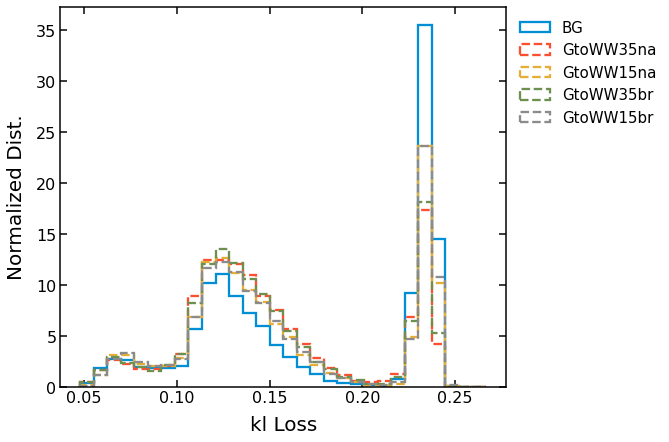

In [13]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for loss in [loss_bg_kl ]:
    max_score = 1.1*np.quantile(loss,0.99)
    min_score = np.min(loss)#,np.max(loss_bg_dist))
    bins = 30
    # plot BG
    plt.figure()
    plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
    for sig in sig_types:
        plt.hist(particles_sig_dict['loss_kl'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
    #plt.semilogy()
    plt.xlabel("kl Loss")
    plt.ylabel("Normalized Dist.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()

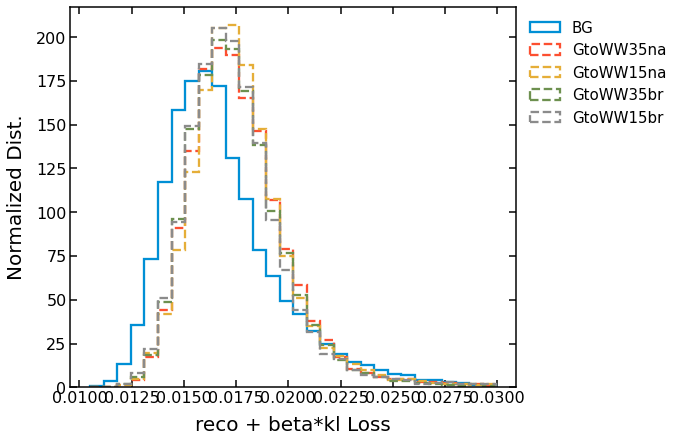

In [14]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

loss =loss_bg_reco+(beta*loss_bg_kl)
max_score = 1.1*np.quantile(loss,0.99)
min_score = np.min(loss)
bins = 30
# plot BG
plt.figure()
plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
        histtype='step', fill=False, linewidth=2.3)
for sig in sig_types:
    plt.hist(particles_sig_dict['loss'][sig]+(beta*particles_sig_dict['loss_kl'][sig]), bins=bins, label=sig, density=True, range=(min_score, max_score), 
        histtype='step', linestyle='--',fill=False, linewidth=2.3)
#plt.semilogy()
plt.xlabel("reco + beta*kl Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
plt.show()

In [15]:
import vande.analysis.analysis_roc as ar

In [16]:
neg_class_losses = [loss_bg_reco]*len(sig_types)
pos_class_losses = []
for sig in sig_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig])

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in sig_types], title='ROC ',
            plot_name='test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


[0.6397549042924546,
 0.6376028648557885,
 0.6283726098686819,
 0.6106562005140723]

In [17]:
beta= vae.beta
neg_class_losses = [loss_bg_reco+(beta*loss_bg_kl)]*len(sig_types)
pos_class_losses = []
for sig in sig_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig]+(beta*particles_sig_dict['loss_kl'][sig]))

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in sig_types], title='ROC ',
            plot_name='test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


[0.6096454626823686,
 0.6151049159788688,
 0.5985032171033283,
 0.5894321424419731]

In [18]:
beta= vae.beta
neg_class_losses = [(beta*loss_bg_kl)]*len(sig_types)
pos_class_losses = []
for sig in sig_types:
    pos_class_losses.append((beta*particles_sig_dict['loss_kl'][sig]))

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in sig_types], title='ROC ',
            plot_name='test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


[0.4048384965540169,
 0.4414784257501195,
 0.40938010919738643,
 0.4452598351868356]

In [19]:
#data_train_generator_2 = dage_pn.DataGenerator(path=paths.sample_dir_path('qcdSide'), 
#                                         sample_part_n=params.gen_part_n, 
#                                          sample_max_n=params.train_total_n, 
#                                          **cuts.global_cuts) # generate 10 M jet samples





In [19]:
#train_ds = tf.data.Dataset.from_generator(data_train_generator,
#                                     (tf.float32, tf.float32),
#                                     (tf.TensorShape([100,2]), tf.TensorShape([100,3]))
#                                         ).batch(params.batch_n, drop_remainder=True) # already shuffled

#train_ds_2 = tf.data.Dataset.from_generator(data_train_generator_2, 
 #                                         output_types=(tf.float32,tf.float32)).batch(params.batch_n, drop_remainder=True) # already shuffled


train_ds_2 = tf.data.Dataset.from_generator(data_train_generator_2, 
                                          output_types=(tf.float32,tf.float32)).batch(params.batch_n, drop_remainder=True) # already shuffled


NameError: name 'data_train_generator_2' is not defined

In [13]:
train_ds_2.take(1)

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [29]:
#new = train_ds_2.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
for data in train_ds_2.take(2):
    print(data)
    break

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py:7: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


AttributeError: 'tuple' object has no attribute 'shape'

In [34]:
data_train_generator = dage.DataGenerator(path=paths.sample_dir_path('qcdSide'),
                                          sample_part_n=params.gen_part_n, 
                                          sample_max_n=params.train_total_n, 
                                          **cuts.global_cuts) # generate 10 M jet samples
train_ds = tf.data.Dataset.from_generator(data_train_generator, 
                                          output_types=tf.float32, 
                                          output_shapes=(100,3)).batch(params.batch_n, drop_remainder=True) # already shuffled


In [36]:
beta= vae.beta


In [11]:
generator = dare.DataReader(paths.sample_dir_path('qcdSide')).generate_event_parts_from_dir(parts_n=256, **cuts.global_cuts)

In [12]:
for constituents, features in generator:
    print(features.shape)
    break

(256, 11)


In [17]:
def our_generator():
    for i in range(1000):
      x = np.random.rand(28,28)
      y = np.random.randint(1,10, size=1)
      yield x,y

In [18]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))


In [21]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))


In [23]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))
dataset = dataset.batch(batch_size=10)
dataset = dataset.repeat(count=2)

for batch, (x,y) in enumerate(dataset):
  pass
print("batch: ", batch)
print("Data shape: ", x.shape, y.shape)

batch:  199
Data shape:  (10, 28, 28) (10, 1)


In [25]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, x_col, y_col=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = # logic
        y = # logic
        
        for i, id in enumerate(batch):
            X[i,] = # logic
            y[i] = # labels

        return X, y

SyntaxError: invalid syntax (<ipython-input-25-623889bf5d6e>, line 29)

In [6]:
import util.prepare_input as inp_prep
reload(inp_prep)

<module 'util.prepare_input' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/prepare_input.py'>

In [7]:
preparator = inp_prep.ParticleInputConversion(path=paths.sample_dir_path('qcdSide'),
                                          sample_part_n=params.gen_part_n, 
                                          outdir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/',
                                          outname = 'test',
                                          **cuts.global_cuts)

In [ ]:
preparator.input_prep()

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/prepare_input.py:12: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_0.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_1.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_2.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_3.h5 
Writing 99992 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_4.h5 
Writing 99996 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_5.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_6.h5 
Writing 99996 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_7.h5 
Writing 

500000.0

In [ ]:
for i in data_train_generator_new():
    print(i)
    break

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


In [ ]:
print('d')

In [12]:
import sarewt.data_reader as dare


In [19]:
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../sarewt_orig/')))
import sarewt_orig.sarewt.data_reader_test as dare_test


In [21]:
#new = train_ds_2.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
for data in ds.take(1):
    print(data)
    break

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts
nb 15, last_batch 0, num_to_process 1500
(<tf.Tensor: shape=(100, 100, 2), dtype=float32, numpy=
array([[[0.357162  , 0.46255153],
        [0.36150497, 0.4663536 ],
        [0.37547597, 0.46752658],
        ...,
        [0.49997225, 0.49997228],
        [0.49997225, 0.49997228],
        [0.49997225, 0.49997228]],

       [[0.57437885, 0.59185755],
        [0.42334905, 0.40506032],
        [0.4143897 , 0.50325876],
        ...,
        [0.5095001 , 0.29539633],
        [0.64263713, 0.5001461 ],
        [0.40599188, 0.30361187]],

       [[0.4587013 , 0.44347426],
        [0.4587013 , 0.44347426],
        [0.45380005, 0.43434384],
        ...,
        [0.49997225, 0.49997228],
        [0.49997225, 0.49997228],
        [0.49997225, 0.49997228]],

       ...,

       [[0.4617828 , 0.5157748 ],
        [0.506907  , 0.508686  ],
        [0.5055718 , 0.5074476 ],
        ...,
     

In [3]:
import tensorflow.experimental.numpy as tnp


ModuleNotFoundError: No module named 'setGPU'

In [26]:
import uproot_methods


ModuleNotFoundError: No module named 'uproot_methods'

In [27]:
1e5

100000.0

In [29]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e3//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

NameError: name 'prepr' is not defined

In [33]:
import pandas as pd
df = pd.read_hdf(filename_bg, key='jetConstituentsList')

TypeError: cannot create a storer if the object is not existing nor a value are passed

In [36]:
import h5py
df = pd.DataFrame(np.array(h5py.File(filename_bg)['jetConstituentsList']))


/tmp/ipykernel_21335/1177929447.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  df = pd.DataFrame(np.array(h5py.File(filename_bg)['jetConstituentsList']))


ValueError: Must pass 2-d input. shape=(867424, 2, 100, 3)